# BusMezzo output analyzer 
Showcase / Tutorial
---
 Rafał Kucharski rkucharski _at_ pk.edu.pl Politechnika Krakowska, Krakow, Poland

---


* We start from BusMezzo output files
* We parse them to panda readable csvs (generated with the scripts on 'input_parsers.ipynb')
* We create pandas DataFrame (sth like SQL tables)
* Analazy them 
* Plot something
* Filter, pivot
* Merge (SQL Join) two tables to get interesting cross-table analyzes
---


In [61]:
import pandas as pd
import os
%matplotlib inline

In [7]:
path = os.path.join('Amsterdam_output',"parsed")

# 1. Reading data

## Read o_transit_trajectory

In [72]:
df1 = pd.read_csv(os.path.join(path,'o_transit_trajectory.csv')).dropna(axis=1)
df1.set_index("Unnamed: 0", inplace = True)
df1.index.name = 'index'
df1.head()

,Line_ID,Trip_ID,Stop_ID,Vehicle_ID,Link_ID,Entering?,Arrival/Departure_time
index,,,,,,,
0,50,5001,5001,5001,50005001,1,180.110
1,50,5001,5001,5001,50005001,0,195.642
2,50,5001,5002,5001,50015002,1,296.642
3,50,5001,5002,5001,50015002,0,312.175
4,50,5001,5003,5001,50025003,1,413.175


### Sample plot: Space-time trajectory of Trip 5001

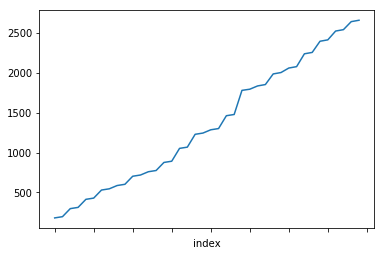

In [68]:
df1[df1.Trip_ID==5001]['Arrival/Departure_time'].plot()

## Read o_segments_trip_loads

In [74]:
df2 = pd.read_csv(os.path.join(path,'o_segments_trip_loads.csv')).dropna(axis=1)
df2.set_index("Unnamed: 0", inplace = True)
df2.index.name = 'index'
df2.head()

,Line_ID,Trip_ID,Vehicle_ID,Start_stop_ID,Start_stop_name,End_stop_id,End_stop_name,Passenger_load
index,,,,,,,,
0,50,5001,-1,5001,Isolatorweg,5002,Station_Sloterdijk,0
1,50,5001,-1,5002,Station_Sloterdijk,5003,Burg_De_Vlugtlaan,0
2,50,5001,-1,5003,Burg_De_Vlugtlaan,5004,Jan_van_Galenstraat,0
3,50,5001,-1,5004,Jan_van_Galenstraat,5005,Postjesweg,0
4,50,5001,-1,5005,Postjesweg,5006,Station_Lelylaan,0


### Sample plot: Distribution of passenger loads (network wide and line 50)

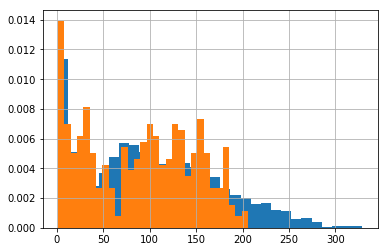

In [82]:
df2.Passenger_load[df2.Passenger_load>0].hist(bins=30, density = True)
df2.Passenger_load[(df2.Passenger_load>0) & (df2.Line_ID == 50)].hist(bins=30, density=True)

### Line loads

In [87]:
df2.groupby("Line_ID").sum()['Passenger_load'].to_frame()

,Passenger_load
Line_ID,
50,33537
51,51810
53,20524
54,37189
250,56887
251,54591
253,23386
254,23701


### Temporal distirbution of line 50 loads

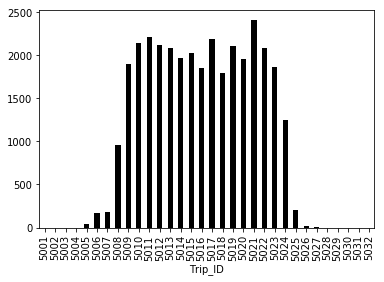

In [92]:
df2[df2.Line_ID == 50].groupby("Trip_ID").sum()['Passenger_load'].plot(kind='bar', color='black')

# 2. Merging two tables

### Travel time table

In [ ]:
result = pd.merge(df1, df2, how='outer', left_on=['Trip_ID', 'Stop_ID'], right_on = ['Trip_ID','Start_stop_ID'])
result.head()

### Create column with end stop id for o_transit_trajectory

In [134]:
df1 = pd.merge(df1, 
                  df2[['Line_ID',"Trip_ID",'Start_stop_ID', 'End_stop_id']], 
                  how='inner', left_on=['Line_ID','Trip_ID', 'Stop_ID'], right_on = ['Line_ID','Trip_ID','Start_stop_ID'])
df1.drop('Start_stop_ID',axis=1, inplace=True)
df1['End_stop_id'].astype(int)
df1.head()

,Line_ID,Trip_ID,Stop_ID,Vehicle_ID,Link_ID,Entering?,Arrival/Departure_time,End_stop_id
0,50,5001,5001,5001,50005001,1,180.110,5002
1,50,5001,5001,5001,50005001,0,195.642,5002
2,50,5001,5002,5001,50015002,1,296.642,5003
3,50,5001,5002,5001,50015002,0,312.175,5003
4,50,5001,5003,5001,50025003,1,413.175,5004


In [145]:
deltas = pd.merge(df1[df1['Entering?']==0],df1[df1['Entering?']==1],on = ['Trip_ID', "Stop_ID"])
deltas = deltas[['Line_ID_x','Trip_ID', "Stop_ID",'Arrival/Departure_time_x','Arrival/Departure_time_y']]
deltas['dwell_time'] = deltas['Arrival/Departure_time_x'] - deltas['Arrival/Departure_time_y']
deltas[deltas.Trip_ID==5030].dwell_time.to_frame()

,dwell_time
544,16.8
545,16.8
546,16.8
547,16.8
548,16.8
549,16.8
550,16.8
551,16.8
552,16.8
553,16.2


In [195]:
travel_times = pd.merge(df1[df1['Entering?']==0],df1[df1['Entering?']==1],left_on = ['Trip_ID', "End_stop_id"], right_on =['Trip_ID', "Stop_ID"])
travel_times = travel_times[['Line_ID_x','Trip_ID', "Stop_ID_x",'Arrival/Departure_time_x','Arrival/Departure_time_y']]
travel_times['travel_time'] = travel_times['Arrival/Departure_time_y'] - travel_times['Arrival/Departure_time_x']
travel_times.head()

,Line_ID_x,Trip_ID,Stop_ID_x,Arrival/Departure_time_x,Arrival/Departure_time_y,travel_time
0,50,5001,5001,195.642,296.642,101.0
1,50,5001,5002,312.175,413.175,101.0
2,50,5001,5003,428.707,529.707,101.0
3,50,5001,5004,545.240,586.240,41.0
4,50,5001,5005,601.772,702.772,101.0


### Link travel time plot

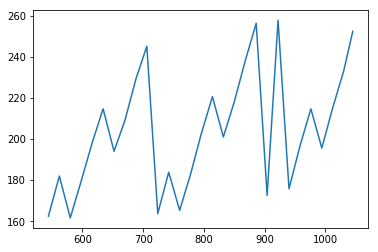

In [196]:
travel_times[(deltas.Line_ID_x==250)&(deltas.Stop_ID_x == 25010)].sort_values(by=['Arrival/Departure_time_x']).travel_time.plot()

### Stop dwell time plot

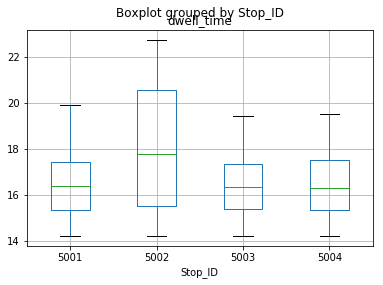

In [197]:
dwell_times = pd.merge(df1[df1['Entering?']==0],df1[df1['Entering?']==1],on = ['Trip_ID', "Stop_ID"])
dwell_times = dwell_times[['Line_ID_x','Trip_ID', "Stop_ID",'Arrival/Departure_time_x','Arrival/Departure_time_y']]
dwell_times['dwell_time'] = dwell_times['Arrival/Departure_time_x'] - dwell_times['Arrival/Departure_time_y']
dwell_times[dwell_times.Stop_ID<5005].boxplot(column='dwell_time',by='Stop_ID')

### Pass hours

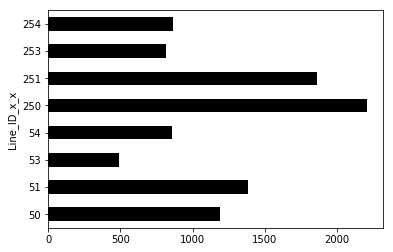

In [227]:
result = pd.merge(travel_times, df2, how='outer', left_on=['Trip_ID', 'Stop_ID_x'], right_on = ['Trip_ID','Start_stop_ID'])
result = pd.merge(dwell_times, result, how='outer', left_on=['Trip_ID', 'Stop_ID'], right_on = ['Trip_ID','Start_stop_ID'])
result['pass_h'] = (result.travel_time  + result.dwell_time) * result.Passenger_load/3600
result.groupby('Line_ID_x_x').sum().pass_h.plot(kind='barh', color='black')